# Team VishValkers' submission for L&T EduTech Hackathon at SHAASTRA IITM

Greetings! We are a team of Machine Learning Enthusiasts who cannot resist a good challenge.
We have solved this problem statement using CNNs, Transfer Learning and Google Colab. We have used our limited resources to develop a deep learning model which can hopefully increase the accuracy of crack detection using ML.



---

                                                          Installations


In [19]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download arunrk7/surface-crack-detection


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
surface-crack-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [20]:
! mkdir ~/.input
! unzip surface-crack-detection.zip -d ~/.input

Streaming output truncated to the last 5000 lines.
  inflating: /root/.input/Positive/14964_1.jpg  
  inflating: /root/.input/Positive/14965_1.jpg  
  inflating: /root/.input/Positive/14966_1.jpg  
  inflating: /root/.input/Positive/14967_1.jpg  
  inflating: /root/.input/Positive/14968_1.jpg  
  inflating: /root/.input/Positive/14969_1.jpg  
  inflating: /root/.input/Positive/14970_1.jpg  
  inflating: /root/.input/Positive/14971_1.jpg  
  inflating: /root/.input/Positive/14972_1.jpg  
  inflating: /root/.input/Positive/14973_1.jpg  
  inflating: /root/.input/Positive/14974_1.jpg  
  inflating: /root/.input/Positive/14975_1.jpg  
  inflating: /root/.input/Positive/14976_1.jpg  
  inflating: /root/.input/Positive/14977_1.jpg  
  inflating: /root/.input/Positive/14978_1.jpg  
  inflating: /root/.input/Positive/14979_1.jpg  
  inflating: /root/.input/Positive/14980_1.jpg  
  inflating: /root/.input/Positive/14981_1.jpg  
  inflating: /root/.input/Positive/14982_1.jpg  
  inflating: /root

In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import shutil
import random
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, r2_score
import os
import glob
import gc
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import warnings, cv2
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from keras.models import Sequential, load_model
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint



---
Data Preprocessing


In [22]:
dir ="/root/.input/"
def load_images(directory):
    images = []
    labels = []
    
    for category in os.listdir(directory):
        for filename in tqdm(os.listdir(directory+category)):
            image_path = os.path.join(directory,category,filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(224,224))
            images.append(image)
            labels.append(category)
    
    images = np.array(images,dtype='float32')
    return images, labels

In [26]:
folderpath="/root/.input/Negative/"
for filename in os.listdir(folderpath):
  if random.random()<=0.9:
    os.remove(folderpath+filename)


In [27]:
folderpath="/root/.input/Positive/"
for filename in os.listdir(folderpath):
  if random.random()<=0.9:
    os.remove(folderpath+filename)


In [28]:
X,y=load_images("/root/.input/")

  0%|          | 0/2039 [00:00<?, ?it/s]

  0%|          | 0/1942 [00:00<?, ?it/s]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [30]:
del X
del y

In [32]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [33]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
ytr=y_train
yte=y_test
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



---
CNN Model


In [34]:
model = Sequential()
model.add(Conv2D(64,3,padding="same", activation="relu",input_shape=(224,224,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256,activation="relu",kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(2, activation="sigmoid"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 128)     

In [35]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

In [36]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=20,mode='max',verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',patience=5,mode='max',verbose=1,factor=0.1,min_lr=0.001)
checkpoint_filename = 'checkpoint/'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filename,monitor='val_accuracy',verbose=1,save_best_only=True,save_weights_only=True,mode='max')

r = model.fit(x=X_train,
            y=y_train,
            epochs=50,
            batch_size=32,
            validation_data=(X_test,y_test),
            callbacks=[early_stopping,reduce_lr,model_checkpoint])
gc.collect()

Epoch 1/50
80/80 [==============================] - ETA: 0s - loss: 0.7615 - accuracy: 0.8241
Epoch 1: val_accuracy improved from -inf to 0.98494, saving model to checkpoint/
80/80 [==============================] - 15s 160ms/step - loss: 0.7615 - accuracy: 0.8241 - val_loss: 0.6713 - val_accuracy: 0.9849 - lr: 0.0010
Epoch 2/50
80/80 [==============================] - ETA: 0s - loss: 0.2947 - accuracy: 0.9698
Epoch 2: val_accuracy did not improve from 0.98494
80/80 [==============================] - 8s 97ms/step - loss: 0.2947 - accuracy: 0.9698 - val_loss: 0.6430 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 3/50
80/80 [==============================] - ETA: 0s - loss: 0.2361 - accuracy: 0.9733
Epoch 3: val_accuracy did not improve from 0.98494
80/80 [==============================] - 8s 94ms/step - loss: 0.2361 - accuracy: 0.9733 - val_loss: 0.4121 - val_accuracy: 0.9310 - lr: 0.0010
Epoch 4/50
80/80 [==============================] - ETA: 0s - loss: 0.2048 - accuracy: 0.9749
Epoch 4: v

2902

In [37]:
model.load_weights(checkpoint_filename)

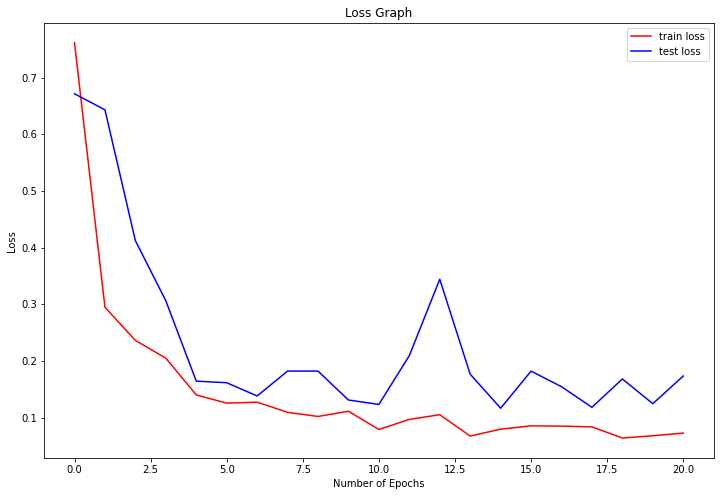

In [38]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

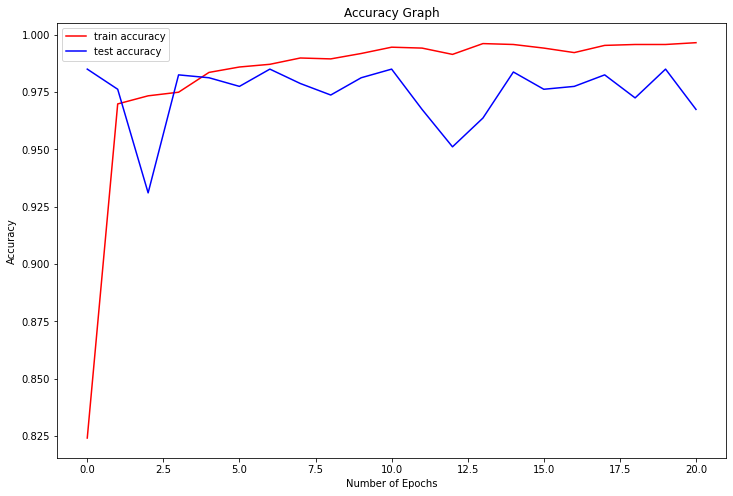

In [39]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [40]:
y_pred_train=model.predict(x=X_train)
y_pred_test=model.predict(x=X_test)

25/25 [==============================] - 1s 34ms/step


In [41]:
y_pred_test=np.argmax(y_pred_test, axis=1)
y_pred_train=np.argmax(y_pred_train, axis=1)

In [42]:
import sklearn.metrics
conftest=sklearn.metrics.confusion_matrix(yte, y_pred_test)
conftrain=sklearn.metrics.confusion_matrix(ytr, y_pred_train)
print(conftest)

[[433   4]
 [  8 352]]


In [43]:
print(conftrain)

[[1279    9]
 [  25 1234]]


In [44]:
print(sklearn.metrics.accuracy_score(yte,y_pred_test))
print(sklearn.metrics.precision_score(yte,y_pred_test))
print(sklearn.metrics.recall_score(yte,y_pred_test))
print(sklearn.metrics.f1_score(yte,y_pred_test))

0.9849435382685069
0.9887640449438202
0.9777777777777777
0.9832402234636872


In [45]:
del X_train
del X_test 
del X_val 
del y_pred_test
del y_pred_train
del y_test
del y_val



---
Applying learnings of CNN to problem statement dataset


In [46]:
! kaggle datasets download xinzone/surface-crack

surface-crack.zip: Skipping, found more recently modified local copy (use --force to force download)


In [47]:
! mkdir ~/.input1
! unzip surface-crack.zip -d ~/.input1

mkdir: cannot create directory ‘/root/.input1’: File exists
Archive:  surface-crack.zip
replace /root/.input1/predict/IMG_1129.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [48]:
train_dir = "/root/.input1/train/"
test_dir = "/root/.input1/test/"

In [49]:
X_train, y_train = load_images(train_dir)
X_test, y_test = load_images(test_dir)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [50]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [51]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
ytr=y_train
yte=y_test
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [52]:
y_pred_train=model.predict(x=X_train)
y_pred_test=model.predict(x=X_test)

7/7 [==============================] - 0s 56ms/step


In [53]:
y_pred_test=np.argmax(y_pred_test, axis=1)
y_pred_train=np.argmax(y_pred_train, axis=1)

In [54]:
import sklearn.metrics
conftest=sklearn.metrics.confusion_matrix(yte, y_pred_test)
conftrain=sklearn.metrics.confusion_matrix(ytr, y_pred_train)
print(conftest)

[[100   0]
 [  1  99]]


In [55]:
print(conftrain)

[[ 10 290]
 [  3 297]]




---


Final Metrics

In [56]:
print(sklearn.metrics.accuracy_score(yte,y_pred_test))
print(sklearn.metrics.precision_score(yte,y_pred_test))
print(sklearn.metrics.recall_score(yte,y_pred_test))
print(sklearn.metrics.f1_score(yte,y_pred_test))

0.995
1.0
0.99
0.9949748743718593
